In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
from user.informed_user import InformedUser

quantity_A = 1715
quantity_B = 8106

price_A = 2533 # ETHUSDT
price_B = 70202 # BTCUSDT

alpha = 0.1 # Fee rate

In [3]:
import numpy as np
from common import get_amm_exchange_value_a_to_b, capital_function
from user.abstract_user import construct_user_swap_a_to_b, construct_user_swap_b_to_a, UserAction
import matplotlib.pyplot as plt
import seaborn as sns

possible_actions: list[tuple[UserAction, bool, float]] = []

LIMIT = 70000

for dx in np.arange(0, LIMIT, 100):
    action = construct_user_swap_a_to_b(
        quantity_A, quantity_B, alpha=alpha, fair_price_A=price_A, fair_price_B=price_B, amount_to_exchange_A=dx
    )
    if action is None:
        continue
    deal_markout = capital_function(action.delta_x, action.delta_y, price_A, price_B)
    possible_actions.append((action, False, deal_markout)) 

for dy in np.arange(0, LIMIT, 100):
    action = construct_user_swap_b_to_a(
        quantity_A, quantity_B, alpha=alpha, fair_price_A=price_A, fair_price_B=price_B, amount_to_exchange_B=dy
    )
    action = UserAction(
        delta_x=action.delta_y,
        delta_y=action.delta_x,
        fee=action.fee
    )
    if action is None:
        continue
    deal_markout = capital_function(action.delta_x, action.delta_y, price_A, price_B)
    possible_actions.append((action, True, deal_markout))

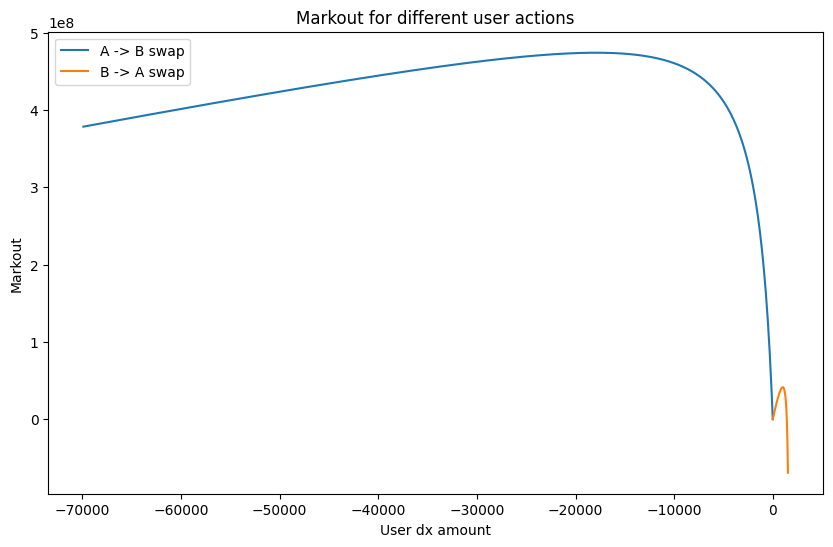

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

possible_actions = sorted(possible_actions, key=lambda x: x[0].delta_x)

a_to_b_actions = [x for x in possible_actions if not x[1]]
b_to_a_actions = [x for x in possible_actions if x[1]]

sns.lineplot(
    x=[x[0].delta_x for x in a_to_b_actions],
    y=[x[2] for x in a_to_b_actions],
    ax=ax,
    label='A -> B swap'
)

sns.lineplot(
    x=[x[0].delta_y for x in b_to_a_actions],
    y=[x[2] for x in b_to_a_actions],
    ax=ax,
    label='B -> A swap'
)

ax.set_xlabel('User dx amount')
ax.set_ylabel('Markout')
plt.title('Markout for different user actions')
plt.legend()
plt.show()

In [5]:
informed_user_action = InformedUser().get_user_action(
    token1_quantity=quantity_A,
    token2_quantity=quantity_B,
    alpha=alpha,
    network_fee=0,
    fair_price_A=price_A,
    fair_price_B=price_B
)

In [6]:
print(informed_user_action)

UserAction(delta_x=np.float64(-19904.15992773454), delta_y=np.float64(7462.969001271606), fee=np.float64(5041723.709695159))
